In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os

In [3]:
# Load the metadata CSV file
metadata_file_path = '/content/drive/MyDrive/CSPII_NIR_Ia_spectra/Lu2023_TableA1_extension.csv'
metadata_df = pd.read_csv(metadata_file_path)

# Directory containing the FITS files
fits_data_directory = '/content/drive/MyDrive/CSPII_NIR_Ia_spectra/observed_spectra/spec_fits'


In [10]:
# Function to process FITS file
def process_fits_file(file_path):
    with fits.open(file_path) as hdul:
        wv, fx, fx_err = hdul[0].data
    reasonable_indices = (wv >= 0.8) & (wv <= 2.5)
    wv = wv[reasonable_indices]
    fx = fx[reasonable_indices]
    fx_err = fx_err[reasonable_indices]
    return wv, fx, fx_err

'''def plot_spectrum(wv, flux, flux_err, title):
            plt.figure(figsize=(12, 6))
            plt.plot(wv, flux, label='Flux')
            plt.fill_between(wv, flux - flux_err, flux + flux_err, color='gray', alpha=0.3, label='Flux Error')
            plt.xlabel('Wavelength (μm)')
            plt.ylabel('Flux')
            plt.title(title)
            plt.legend()
            plt.show()'''

# Function to extract features from the spectrum
def extract_features(wv, fx):
    features = {}
    features['mean_flux'] = np.mean(fx)
    features['median_flux'] = np.median(fx)
    features['std_flux'] = np.std(fx)
    features['max_flux'] = np.max(fx)
    features['min_flux'] = np.min(fx)
    features['wavelength_at_max_flux'] = wv[np.argmax(fx)]
    features['wavelength_at_min_flux'] = wv[np.argmin(fx)]

     # Calculation of flux in specific bands (Y: 1.0-1.1 µm, J: 1.1-1.4 µm, H: 1.5-1.8 µm, K: 2.0-2.5 µm)
    features['flux_Y'] = np.mean(fx[(wv >= 1.0) & (wv <= 1.1)])
    features['flux_J'] = np.mean(fx[(wv >= 1.1) & (wv <= 1.4)])
    features['flux_H'] = np.mean(fx[(wv >= 1.5) & (wv <= 1.8)])
    features['flux_K'] = np.mean(fx[(wv >= 2.0) & (wv <= 2.5)])

    return features

# Initialize an empty list to store features
features_list = []

# Process each file listed in the metadata
for index, row in metadata_df.iterrows():
    filename = row['filename']
    file_path_fits = os.path.join(fits_data_directory, f'{filename}.fits')
    zhel = row['zhel']
    Tmax = row['Tmax(MJD)']
    sBV = row['sBV']

    try:
        if os.path.exists(file_path_fits):
            wv, fx, fx_err = process_fits_file(file_path_fits)
            rest_wavelength = wv/ (1+zhel)

            '''if wv is not None:

                features['filename'] = filename
                features['zhel'] = zhel
                features['Tmax(MJD)'] = Tmax
                features['sBV'] = sBV
                features = extract_features(rest_wavelength, fx)
                features_list.append(features)
        else:
            continue'''

            if wv is not None:
                features = {
                    'filename': filename,
                    'zhel': zhel,
                    'Tmax(MJD)': Tmax,
                    'sBV': sBV
                }
                extracted_features = extract_features(rest_wavelength, fx)
                features.update(extracted_features)
                features_list.append(features)
        else:
            continue



    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        continue

# Convert the features list to a DataFrame
features_df = pd.DataFrame(features_list)

# Save the features to a CSV file
features_df.to_csv('extracted_features.csv', index=False)

# Display the first few rows of the features DataFrame
features_df.head()


,filename,zhel,Tmax(MJD),sBV,mean_flux,median_flux,std_flux,max_flux,min_flux,wavelength_at_max_flux,wavelength_at_min_flux,flux_Y,flux_J,flux_H,flux_K
0,ASAS14ad_20140208_fire,0.0264,56692.7,1.013,4.216527e-16,2.181891e-16,4.569898e-16,3.187331e-15,-3.314887e-16,0.781008,2.421794,2.616835e-16,1.770716e-16,7.008082e-17,3.677074e-17
1,ASAS14ad_20140215_fire,0.0264,56692.7,1.013,3.776562e-16,1.815052e-16,4.619959e-16,2.513188e-15,-1.400979e-15,0.785246,2.432642,2.390821e-16,1.088961e-16,1.189426e-16,5.377226e-17
2,ASAS14ad_20140222_fire,0.0264,56692.7,1.013,6.382111e-15,2.303491e-15,9.306037e-15,4.155343e-14,-7.336957e-15,0.869730,2.410336,5.839983e-15,1.654553e-15,2.229334e-15,1.010692e-15
3,ASAS14ad_20140227_fire,0.0264,56692.7,1.013,1.011366e-14,4.019668e-15,5.530620e-14,1.786641e-12,-2.337041e-15,0.782077,2.415819,8.373535e-15,2.476321e-15,3.471668e-15,1.805622e-15
4,ASAS14ad_20140310_fire,0.0264,56692.7,1.013,1.521564e-15,2.831000e-16,4.166121e-14,1.681415e-12,-5.012777e-13,0.782852,0.782501,9.805629e-16,2.329618e-16,1.493026e-16,5.941049e-17


In [13]:
# Display initial missing values
print("Initial missing values:\n", features_df.isnull().sum())

# Remove rows with any missing values
features_df_cleaned = features_df.dropna()

# Recheck missing values to ensure they have been removed
print("Missing values after removing rows:\n", features_df_cleaned.isnull().sum())

# Optionally, save the cleaned dataset to a new CSV file
features_df_cleaned.to_csv('extracted_features_cleaned.csv', index=False)

# Display the first few rows of the cleaned DataFrame
print(features_df_cleaned.head())


Initial missing values:
 filename                  0
zhel                      0
Tmax(MJD)                 0
sBV                       0
mean_flux                 2
median_flux               2
std_flux                  2
max_flux                  2
min_flux                  2
wavelength_at_max_flux    0
wavelength_at_min_flux    0
flux_Y                    0
flux_J                    0
flux_H                    0
flux_K                    2
dtype: int64
Missing values after removing rows:
 filename                  0
zhel                      0
Tmax(MJD)                 0
sBV                       0
mean_flux                 0
median_flux               0
std_flux                  0
max_flux                  0
min_flux                  0
wavelength_at_max_flux    0
wavelength_at_min_flux    0
flux_Y                    0
flux_J                    0
flux_H                    0
flux_K                    0
dtype: int64
                 filename    zhel  Tmax(MJD)    sBV     mean_flux  \
0  

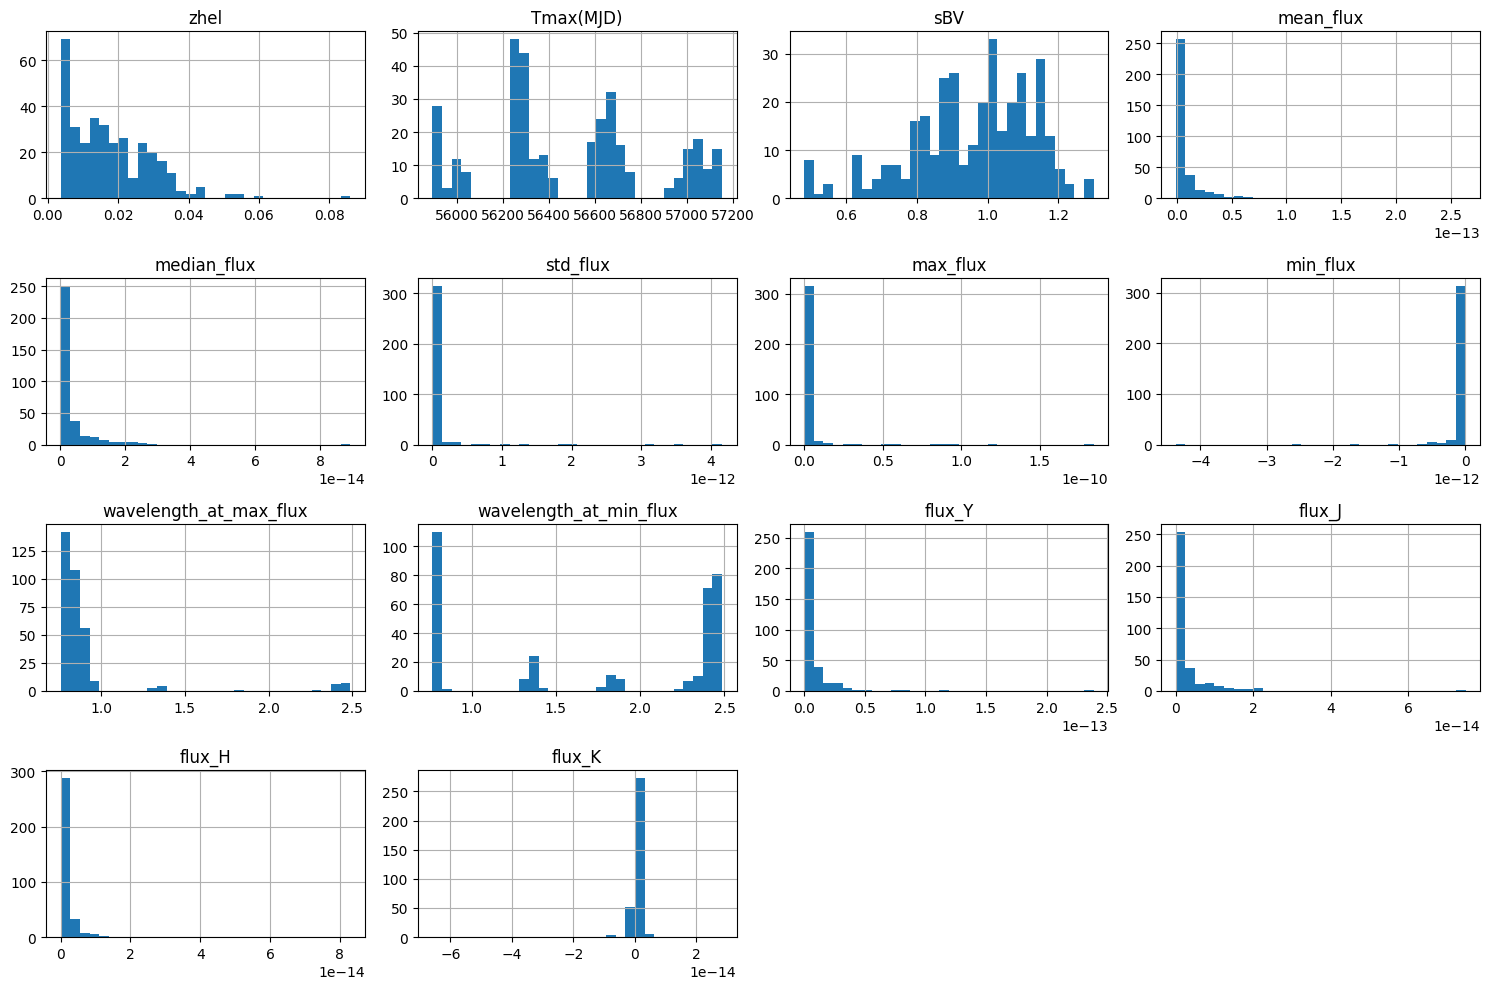

In [15]:

features_copy = features_df_cleaned
import matplotlib.pyplot as plt

# List of columns to plot, excluding non-numeric columns
features_to_plot = [col for col in features_copy.columns if col not in ['filename']]

# Plot histograms for each feature
features_copy[features_to_plot].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


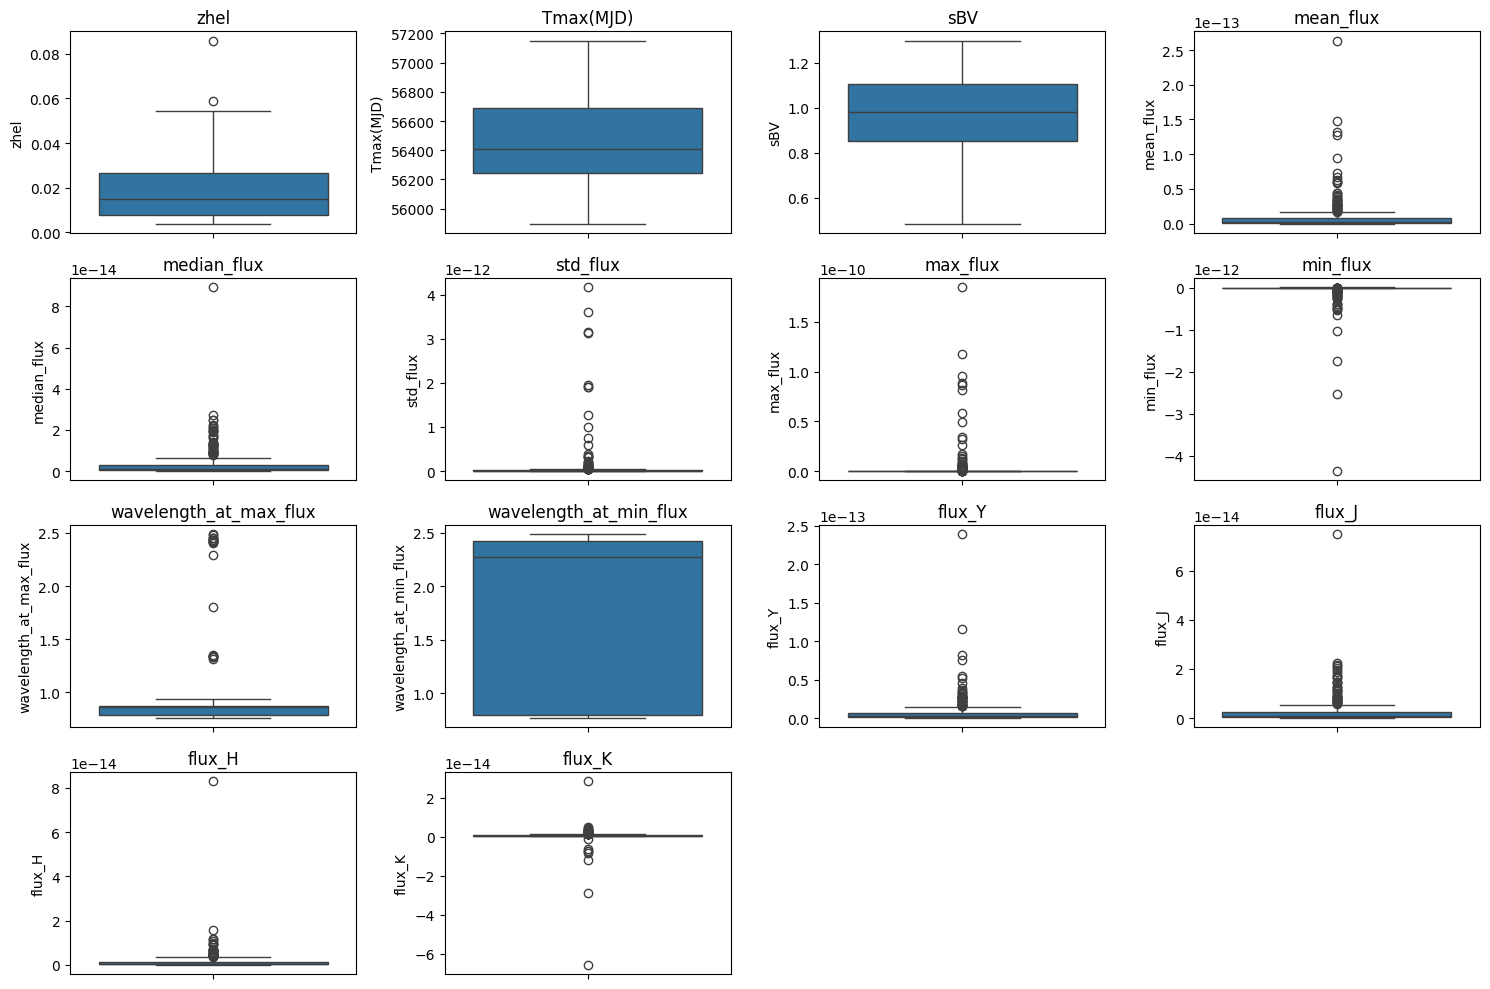

In [16]:
import seaborn as sns

# Plot boxplots for each feature
plt.figure(figsize=(15, 10))
for i, column in enumerate(features_to_plot):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=features_copy[column])
    plt.title(column)
plt.tight_layout()
plt.show()


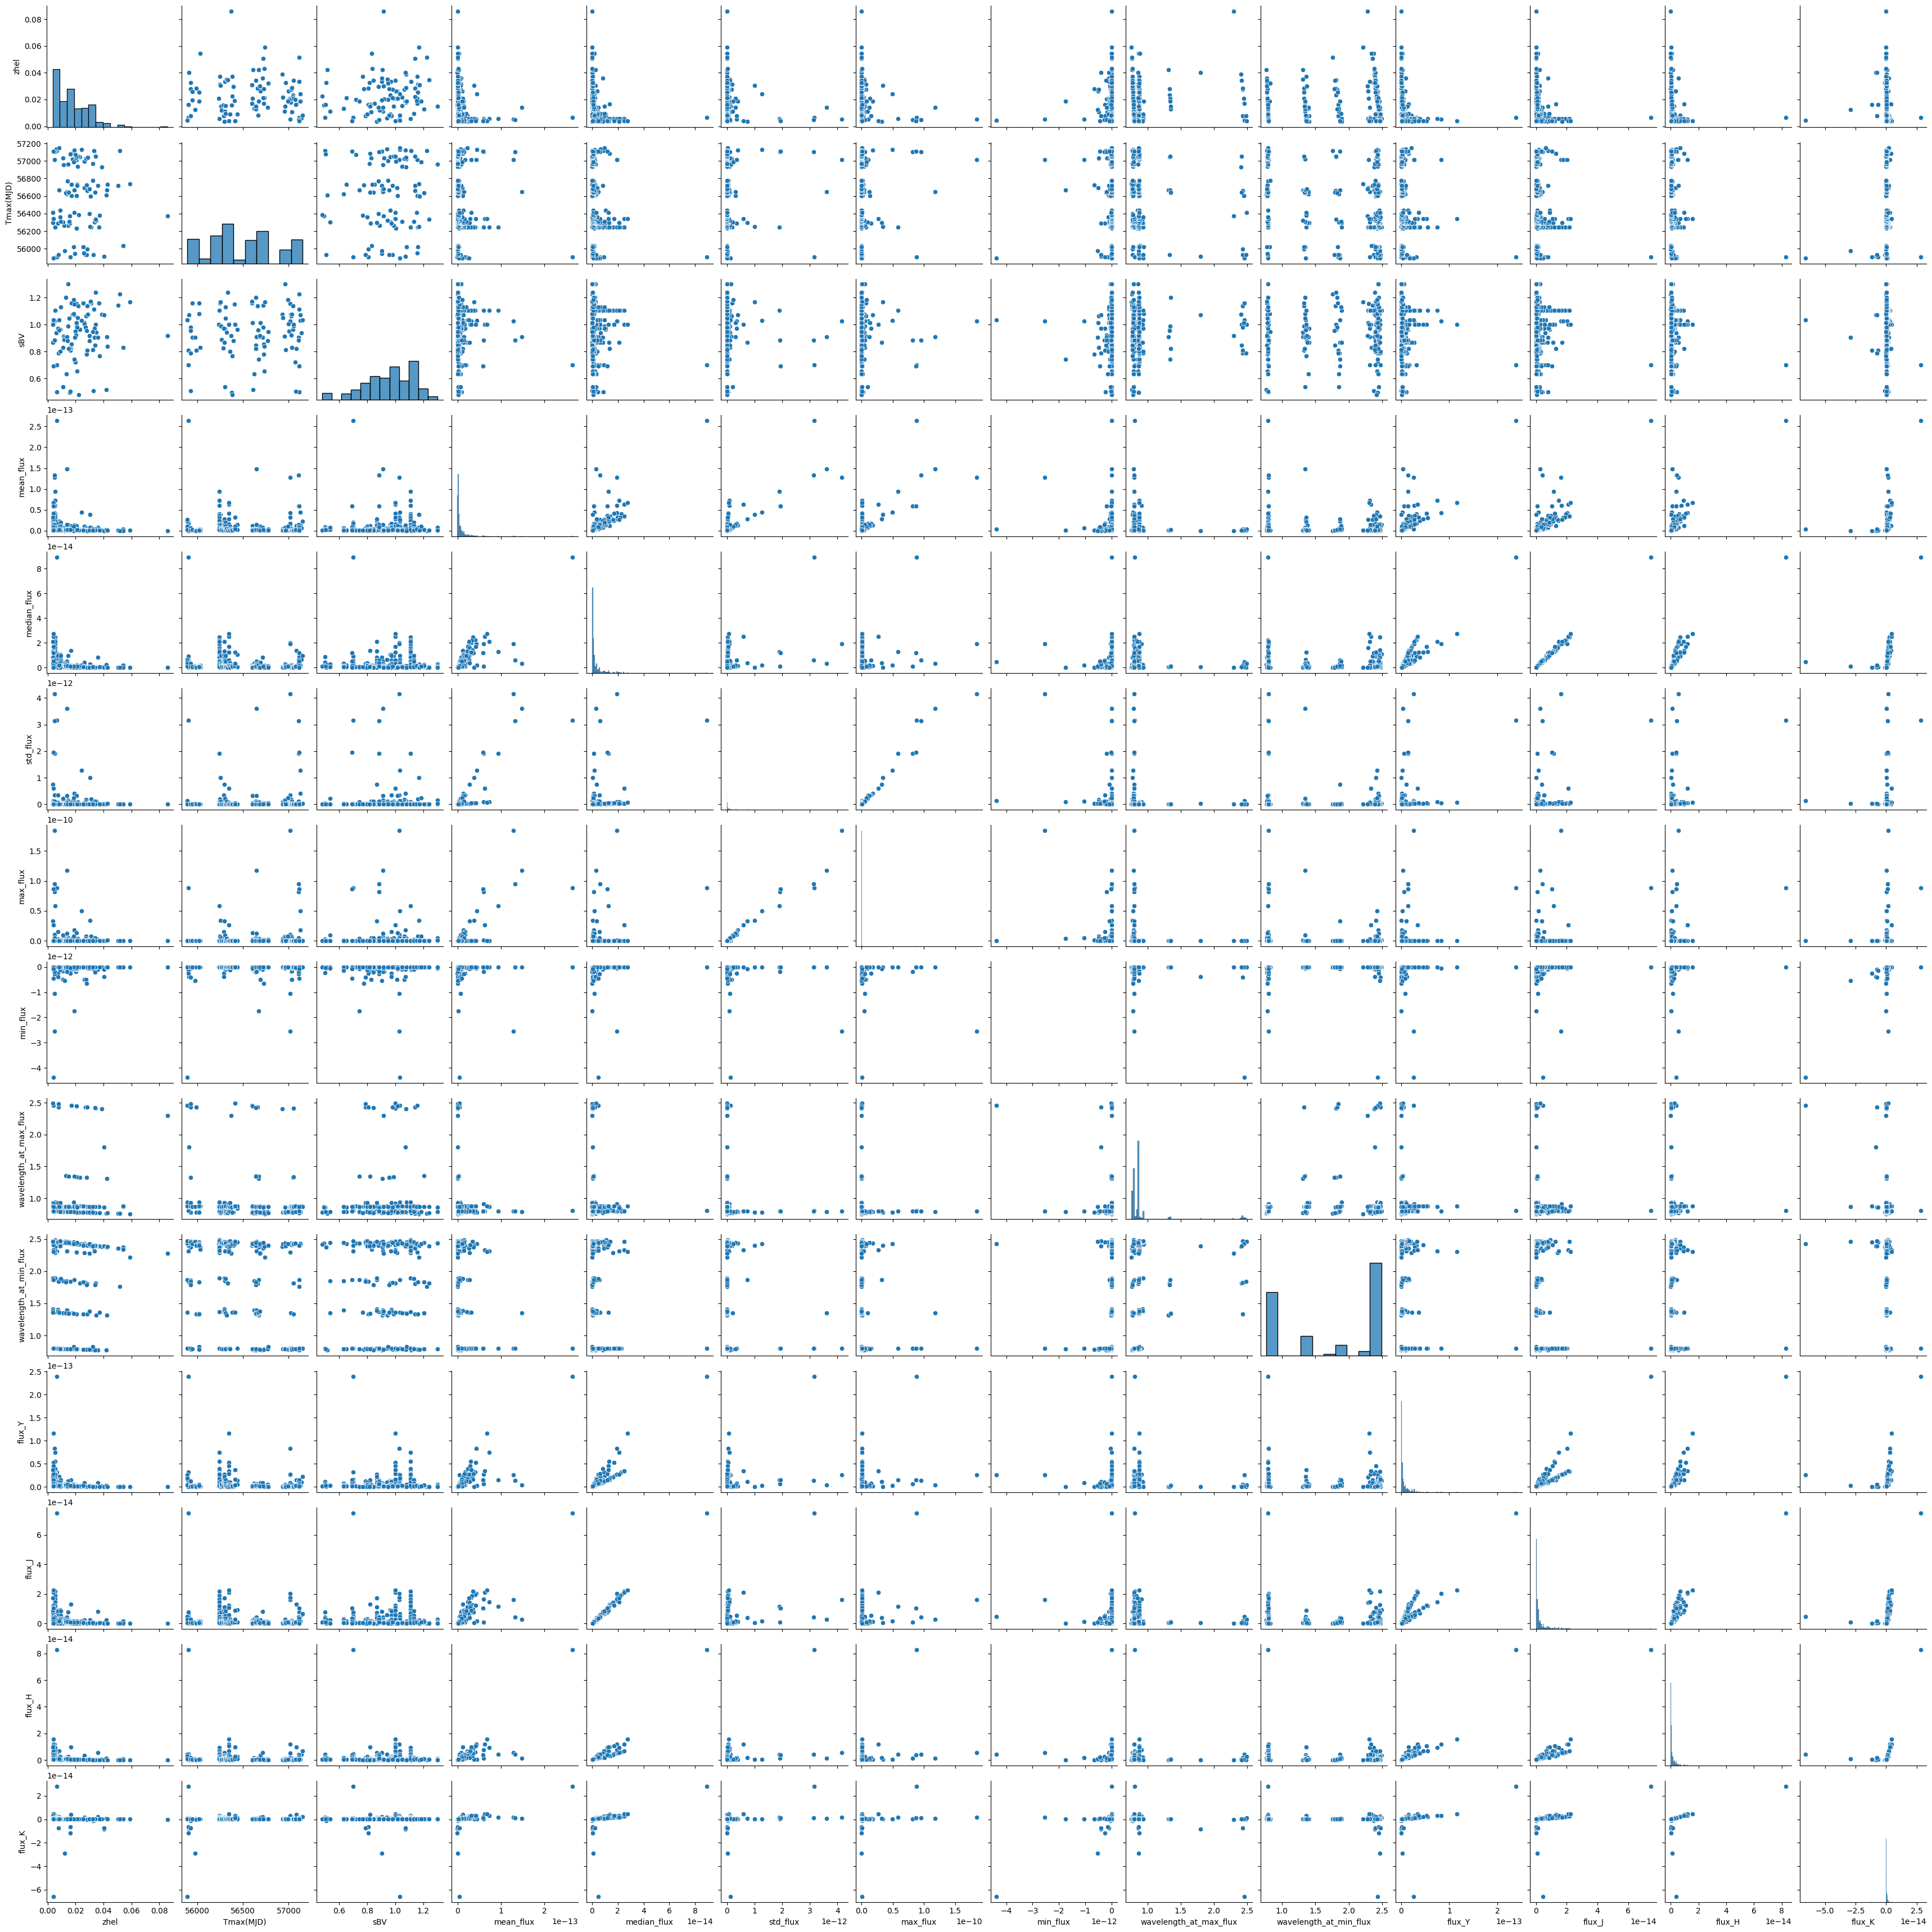

In [17]:
# Plot pairwise relationships
sns.pairplot(features_copy[features_to_plot])
plt.show()


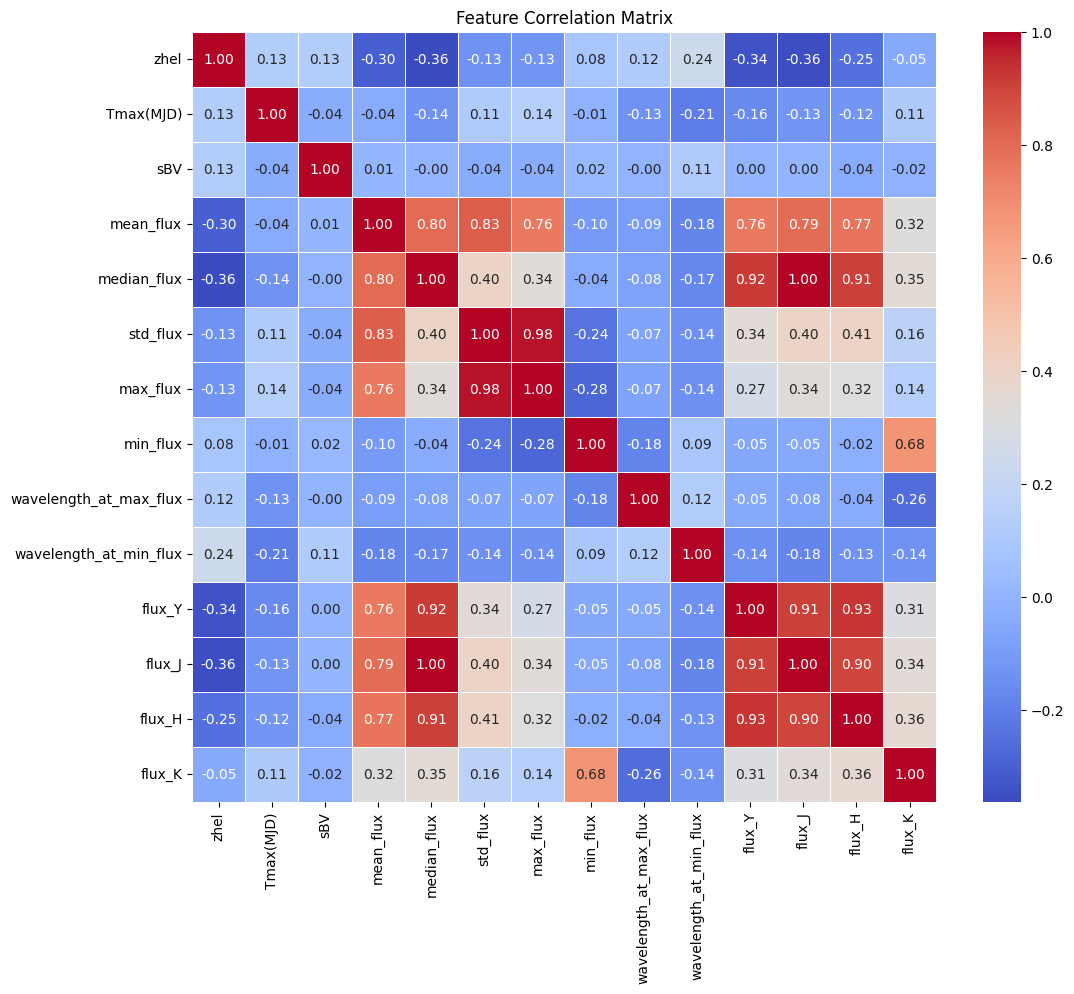

In [19]:
# Compute correlation matrix
correlation_matrix = features_copy[features_to_plot].corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()


In [20]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale features
features_scaled = scaler.fit_transform(features_copy[features_to_plot])

# Create a DataFrame for the scaled features
features_scaled_df = pd.DataFrame(features_scaled, columns=features_to_plot)


In [21]:
from sklearn.cluster import KMeans

# Initialize KMeans with a number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model
clusters = kmeans.fit_predict(features_scaled_df)

# Add cluster labels to the DataFrame
features_copy['cluster'] = clusters

# Display the first few rows with cluster labels
print(features_copy.head())


                 filename    zhel  Tmax(MJD)    sBV     mean_flux  \
0  ASAS14ad_20140208_fire  0.0264    56692.7  1.013  4.216527e-16   
1  ASAS14ad_20140215_fire  0.0264    56692.7  1.013  3.776562e-16   
2  ASAS14ad_20140222_fire  0.0264    56692.7  1.013  6.382111e-15   
3  ASAS14ad_20140227_fire  0.0264    56692.7  1.013  1.011366e-14   
4  ASAS14ad_20140310_fire  0.0264    56692.7  1.013  1.521564e-15   

    median_flux      std_flux      max_flux      min_flux  \
0  2.181891e-16  4.569898e-16  3.187331e-15 -3.314887e-16   
1  1.815052e-16  4.619959e-16  2.513188e-15 -1.400979e-15   
2  2.303491e-15  9.306037e-15  4.155343e-14 -7.336957e-15   
3  4.019668e-15  5.530620e-14  1.786641e-12 -2.337041e-15   
4  2.831000e-16  4.166121e-14  1.681415e-12 -5.012777e-13   

   wavelength_at_max_flux  wavelength_at_min_flux        flux_Y        flux_J  \
0                0.781008                2.421794  2.616835e-16  1.770716e-16   
1                0.785246                2.432642  2.390

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-21-20b5498c6d23>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_copy['cluster'] = clusters


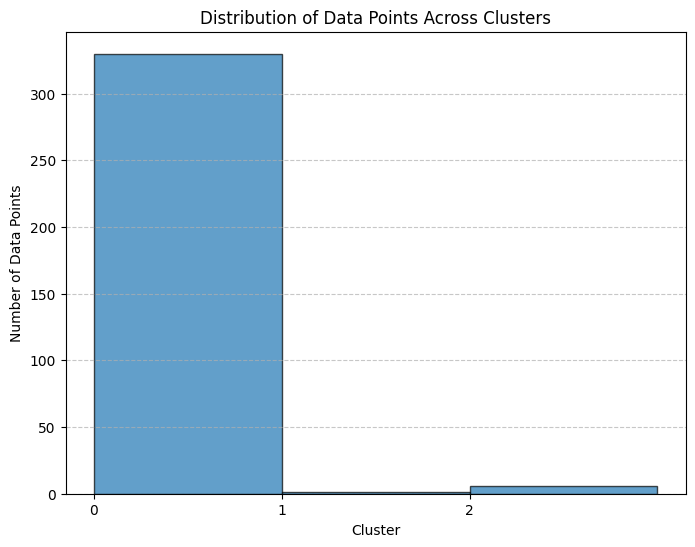

In [22]:
import matplotlib.pyplot as plt

# Plot histogram of cluster distribution
plt.figure(figsize=(8, 6))
plt.hist(features_copy['cluster'], bins=range(features_copy['cluster'].nunique() + 1), edgecolor='k', alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data Points Across Clusters')
plt.xticks(range(features_copy['cluster'].nunique()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
